# 02. Data Engineering

In this notebook, we will transform the data to fit the format required for our model and we will create new features to add valuable info to it. 

To start this notebook we will use the DataFrame we generated in Cleaning_Data.

## Loading libraries and data

In [53]:
import pandas as pd
import revesFunctions as rf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import pickle

In [27]:
reves = pd.read_pickle("data/cleaned_reves_df.pkl")

In [28]:
reves.sample(5)

,directors,writers,belongs_to_collection,genres,original_language,production_companies,revenue,runtime,title,keywords,release_year,release_month,release_weekday,cast_names,cast_gender
2073,[Martin Campbell],"[Richard Herley, Michael Gaylin, Joel Gross]",NaN,"[Action, Drama, Science Fiction, Thriller]",en,"[Columbia Pictures Corporation, Pacific Wester...",15340000.0,118.0,No Escape,"[prison, island, chase, dystopia, prison guard...",1994.0,4.0,4.0,"[Ray Liotta, Lance Henriksen, Stuart Wilson, K...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, ..."
470,[Blake Edwards],"[Frank Waldman, Blake Edwards]",The Pink Panther (Original) Collection,"[Mystery, Comedy, Crime]",en,"[United Artists, Jewel Productions, Pimlico Fi...",41833347.0,113.0,The Return of the Pink Panther,"[robbery, diamant, côte d'azur, inspector, pan...",1975.0,5.0,2.0,"[Peter Sellers, Christopher Plummer, Herbert L...","[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1320,[Joan Micklin Silver],[Susan Sandler],NaN,"[Comedy, Drama, Romance]",en,[Warner Bros.],16262415.0,97.0,Crossing Delancey,"[matchmaking, woman director, pickles]",1988.0,9.0,4.0,"[Amy Irving, Peter Riegert, Reizl Bozyk, Jeroe...","[1, 2, 0, 0, 1, 2, 2, 1, 2]"
6257,[Drake Doremus],"[Drake Doremus, Ben York Jones]",NaN,[Drama],en,"[Indian Paintbrush, Super Crispy Entertainment]",15000.0,98.0,Breathe In,"[new york, exchange, marriage, crisis, party, ...",2013.0,1.0,4.0,"[Guy Pearce, Felicity Jones, Amy Ryan, Mackenz...","[2, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 2, 2]"
6442,[Kevin Macdonald],[Dennis Kelly],NaN,[Adventure],en,"[Cowboy Films, Film4, Focus Features]",1171559.0,115.0,Black Sea,"[submarine, captain]",2014.0,12.0,4.0,"[Jude Law, Karl Davies, Jodie Whittaker, Danie...","[2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, ..."


## Let's perform some data transformation

#### Revenue & Release Year

First of all, we should transform the value to predict: revenue. Why? Becasuse we ought to know that the price of money has changed through the years, and we have movies in our dataset released since 1930 to 2015.The $100 milions raised on 1950 are definetely not worth the same than today. Movie theatre's ticket price has also changed, and we need to find a way to balance between values from different years.

To do so we have used an external data source to perform a CPI-based transformation. You can find de data and the explanation of how we've transformed the values here:

- Data: https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/

- Process: https://www.usinflationcalculator.com/frequently-asked-questions-faqs/#HowInflationCalculatorWorks

The data from the above-linked source has been downloaded as a .xslx file to be used with Pandas. Data has been transformed up to 2017. 

In [29]:
cpi_df = pd.read_excel("data/CPI_data.xlsx")
cpi_dict = dict(zip(cpi_df["Year"], cpi_df["Avg"]))
reves["cpi"] = reves["release_year"].apply(lambda x: cpi_dict[x] if x in cpi_dict else 0)
reves["revenue_inflated"] = reves["revenue"] * (cpi_dict[2017] / reves["cpi"])

In [30]:
reves[["revenue", "revenue_inflated", "release_year", "title"]].sort_values(by = "revenue_inflated", ascending = False).head(5)

,revenue,revenue_inflated,release_year,title
58,4.001765e+08,7.056925e+09,1939.0,Gone with the Wind
123,5.720000e+08,5.392640e+09,1951.0,Alice in Wonderland
75,2.674472e+08,4.021880e+09,1942.0,Bambi
4537,2.787965e+09,3.185399e+09,2009.0,Avatar
54,1.849255e+08,3.147843e+09,1937.0,Snow White and the Seven Dwarfs


As we see, results are not the same if we compare the top revenue ranking with and without the transformation performed.

In [31]:
print("Top movie (original revenue)")
reves[["revenue", "revenue_inflated", "release_year", "title"]].sort_values(by = "revenue", ascending = False).head(1)

Top movie (original revenue)


,revenue,revenue_inflated,release_year,title
4537,2.787965e+09,3.185399e+09,2009.0,Avatar


In [32]:
print("Top movie (revenue inflated)")
reves[["revenue", "revenue_inflated", "release_year", "title"]].sort_values(by = "revenue_inflated", ascending = False).head(1)

Top movie (revenue inflated)


,revenue,revenue_inflated,release_year,title
58,400176459.0,7.056925e+09,1939.0,Gone with the Wind


#### Belongs to collection

As seen in the previous notebook, whether a movie that belongs to a collection or franchise or not influences the potential revenue. Mean-talking, a movie that do belongs to a series has a higher revenue value than the ones that doesn't. We have also established that some of those collections raise more money than others. That is why we are not only informing our model with a one hot encoding variable. Instead of that, we are using the name of the collection itself to get a more accurate prediction of the revenue. 

The engineering performed in this case consists on assigning to each movie a score based on the mean-revenue value raised by it's collection or franchise. When the movie doesn't belong to any collection, the assigned score will be the mean revenue of all the non-collection movies, which is the same as saying that the value will be the mean revenue for the "No" collection movies.

To do this, we will import 2 own functions defined in RevesFunctions library.
* word_mean
* get_mean

Prior to this processing, we will apply a text-cleaning removing special characters, orthografic accents, and removing capital letters. This process should also be applied later to the data we use when making predictions. 

In [33]:
reves["belongs_to_collection"] = reves["belongs_to_collection"].apply(lambda x: ["no"] if pd.isnull(x) else [x])
reves["belongs_to_collection"] = reves["belongs_to_collection"].apply(lambda x: [rf.clean(name) for name in x])
collection_dict = rf.word_mean(reves, "belongs_to_collection", "revenue_inflated")
reves["collection_score"] = reves["belongs_to_collection"].apply(rf.get_mean, variable_mean_dict = collection_dict)

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


In [34]:
reves[["collection_score", "belongs_to_collection","revenue", "title"]].sort_values(by = "collection_score", ascending = False).head(5)

,collection_score,belongs_to_collection,revenue,title
75,4.021880e+09,[bambi collection],2.674472e+08,Bambi
4537,3.185399e+09,[avatar collection],2.787965e+09,Avatar
118,2.680976e+09,[cinderella collection],2.635914e+08,Cinderella
233,1.769783e+09,[101 dalmatians animated collection],2.158800e+08,One Hundred and One Dalmatians
2666,1.584568e+09,[star wars collection],8.500000e+08,Star Wars: Episode III - Revenge of the Sith


#### The score transformations

The score transformation performed with Belongs to Collection will be the standard transfomation that we will apply to other features from now on during this notebook. We will ajust it depending on the feature itself and its values, but all of them will be based in this same criteria. 

We will do so because we plan on developing a XGboost model, but we have categorical variables that we must transform into numeric values in order to be used in the model. 

#### Genres

In order to use data in Genres, we will drop rows with no values first. Then, we are going to check if the total ammount of genres assigned to a movie influence the potential revenue, as we think that the number of genres associated to a movie could be related to the complexity of the plot, and eventually to the movie's potential revenue.

In [35]:
reves = reves[reves["genres"].str.len() != 0].reset_index(drop = True)
reves["genres_count"] = reves["genres"].apply(lambda x: len(x))

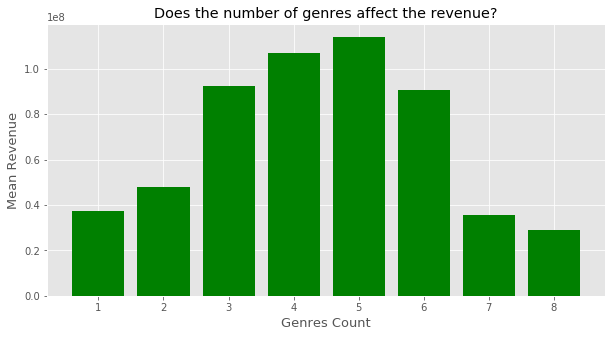

In [36]:
plt.subplots(figsize = (10, 5))
plt.bar(reves.groupby("genres_count")["genres_count"].count().index
         ,reves.groupby("genres_count")["revenue"].mean(),
       color="green",label="mean revenue")
plt.ylabel("Mean Revenue", fontsize = 13)
plt.xlabel("Genres Count", fontsize = 13)
plt.title("Does the number of genres affect the revenue?");

On the first iteration, we thought of creating one hot encoding columns for each of the genres, to indicate with 1 or 0 whether the movie had that genre assigned or not, but that would have added 20 columns to our model and that wouldn't have added any value. Finally we decided to transform this column applying to each movie a value obtained by generating the mean of the mean revenue for each genre assigned to it. 

In [37]:
reves["genres"] = reves["genres"].apply(lambda x: [rf.clean(name) for name in x])
genres_dict = rf.word_mean(reves, "genres", "revenue_inflated")
reves["genres_score"] = reves["genres"].apply(rf.get_mean, variable_mean_dict = genres_dict)

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


In [38]:
reves[["genres", "genres_score", "revenue_inflated", "title"]].sort_values(by = "genres_score", ascending = False).head(5)

,genres,genres_score,revenue_inflated,title
7036,[animation],2.679820e+08,1.626846e+07,Mune: Guardian of the Moon
2958,[animation],2.679820e+08,2.460894e+08,Pokémon: The First Movie: Mewtwo Strikes Back
2100,[animation],2.679820e+08,1.616214e+07,The Swan Princess
6596,[animation],2.679820e+08,2.546512e+08,The Peanuts Movie
983,[animation],2.679820e+08,4.849706e+07,The Black Cauldron


In [39]:
sorted(genres_dict, key = genres_dict.get, reverse = True)[:5]

['animation', 'adventure', 'family', 'fantasy', 'science fiction']

 
 
#### Original Language

We'll do the same as before, now with Original Language: applying mean revenue value for each language.

In [40]:
reves["original_language"] = reves["original_language"].apply(lambda x: [x])
reves["original_language"] = reves["original_language"].apply(lambda x: [rf.clean(name) for name in x])
language_dict = rf.word_mean(reves, "original_language", "revenue_inflated")
reves["language_score"] = reves["original_language"].apply(rf.get_mean, variable_mean_dict = language_dict)

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


In [41]:
reves[["original_language","language_score", "revenue_inflated", "title"]].sort_values(by = "language_score", ascending = False).head(5)

,original_language,language_score,revenue_inflated,title
0,[en],1.188783e+08,2.669624e+08,The Birth of a Nation
4210,[en],1.188783e+08,1.739583e+07,The Assassination of Jesse James by the Coward...
4208,[en],1.188783e+08,9.474125e+07,The Sentinel
6768,[en],1.188783e+08,3.126346e+07,Far from the Madding Crowd
4206,[en],1.188783e+08,3.371057e+06,Killshot


In [42]:
sorted(language_dict, key = language_dict.get, reverse = True)[:5]

['en', 'xx', 'zh', 'ja', 'te']

  
#### Production company

First of all, we will drop the rows with no production companies data. Then, we will check if the number of production companies (not the companies themselves, but how many) influences potential revenue.

In [43]:
reves = reves[reves["production_companies"].str.len() != 0].reset_index(drop = True)
reves["production_companies_count"] = reves["production_companies"].apply(lambda x: len(x))

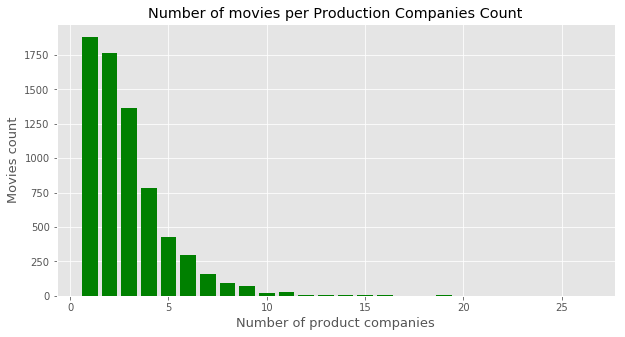

In [44]:
plt.figure(figsize = (10, 5))
plt.bar(reves.groupby("production_companies_count").count()["title"].index,
        reves.groupby("production_companies_count").count()["title"].values,color="green")
plt.ylabel("Movies count", fontsize = 13)
plt.xlabel("Number of product companies", fontsize = 13)
plt.title("Number of movies per Production Companies Count");
plt.show()

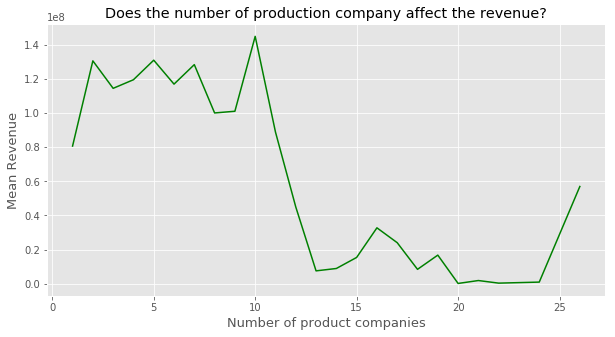

In [45]:
plt.figure(figsize = (10, 5))
plt.plot(reves.groupby("production_companies_count").mean()["revenue_inflated"], color = "green")
plt.ylabel("Mean Revenue", fontsize = 13)
plt.xlabel("Number of product companies", fontsize = 13)
plt.title("Does the number of production company affect the revenue?");

Seems that there's actually an influence, that is why we will create a column with the number of production-companies' count. Also, we will transform this variable as we did above with other similar features.

In [46]:
reves["production_companies"] = reves["production_companies"].apply(lambda x: [rf.clean(name) for name in x])
production_company_dict = rf.word_mean(reves, "production_companies", "revenue_inflated")
reves["companies_score"] = reves["production_companies"].apply(rf.get_mean, variable_mean_dict = production_company_dict)

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


In [47]:
reves[["production_companies","companies_score", "revenue_inflated", "title"]].sort_values(by = "companies_score", ascending = False).head(5)

,production_companies,companies_score,revenue_inflated,title
68,[selznick international pictures],2.419100e+09,1.050514e+08,Rebecca
95,[selznick international pictures],2.419100e+09,9.532444e+07,Spellbound
434,"[warner bros, hoya productions]",1.312827e+09,2.436328e+09,The Exorcist
58,"[selznick international pictures, metrogoldwyn...",1.281629e+09,7.056925e+09,Gone with the Wind
2148,[lightstorm entertainment],1.113898e+09,1.280172e+07,Strange Days


In [48]:
sorted(production_company_dict, key = production_company_dict.get, reverse = True)[:5]

['hoya productions',
 'selznick international pictures',
 'argyle enterprises',
 'abu dhabi film commission',
 'colorado office of film television media']


#### Cast

In [49]:
reves = reves[reves["cast_names"].str.len() != 0].reset_index(drop = True)
reves["cast_names"] = reves["cast_names"].apply(lambda x: [rf.clean(name) for name in x])
cast_dict = rf.word_mean(reves, "cast_names","revenue_inflated")

print("There are %d unique cast_names" %(len(cast_dict.keys())))

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


There are 75700 unique cast_names


There are too many unique values to use in a model without overfitting, and also, too many values for a one hot encoding of this column. We need to simplify this information ir order to use it in Reves. 

There are many strategies we could follow: clustering actors by rating, clustering actors by mean revenue, replace "actor_name" with some actor's feature, etc. We have searched for datasets that may contain a ranking of actors that we could use for clustering, but they do not have all the names that appear in our main dataset, and we do the merge, we have too many missing values. 

In a real version of Reves we think that a great strategy will be using a clustering by actor's mean earnings or popularity. That information is easy to get for a production company though it's not available for us at this point of Reves development. 

The question is: What is the best Reves could learn from the data that we currently have?

We think that is interesting to try 2 features:

- Number of characters/actors. Since it might have something to do with the plot's complexity.
- Main roles genres. Is the main lead a female or a male?


In [54]:
reves["number_of_characters"]=rf.lenght("cast_names")

AttributeError: module 'revesFunctions' has no attribute 'lenght'

In [55]:
plt.figure(figsize = (10, 5))

fig = plt.scatter(x = reves["number_of_characters"], y = reves["revenue"],color="green")

plt.ylabel("Number of characters", fontsize = 13)
plt.xlabel("Revenue", fontsize = 13)
plt.title("Relation between number_of_characters and revenue")

plt.show()

KeyError: 'number_of_characters'

<Figure size 720x360 with 0 Axes>

Seems like an interesting issue to analyze. Maybe more cast members equals more budget and that's defenitely a factor for higher potential income.

Nevertheless, we wont' use this information in Reves since it has been designed as a tool to movie planning for production companies. When companies use Reves, they won't know in advance how many actors and actresses they are going to use. We need to stick to the data we are going to have/know at the app's moment of use.

After evaluating all this posibilities, we have decided to do the same as we did with the columns above: this time, we will generate a new column based on the mean revenue value generated by the 4 main characters/roles of the cast. (We've made some tests using the whole cast but they really didn't better the error although they add a lot more information to process). 

In [57]:
reves["cast_names"] = reves["cast_names"].apply(lambda x: x[:4])
reves["cast_score"] = reves["cast_names"].apply(rf.get_mean, variable_mean_dict = cast_dict)

In [58]:
reves[["cast_names","cast_score", "revenue_inflated", "title"]].sort_values(by = "cast_score", ascending = False).head(5)

,cast_names,cast_score,revenue_inflated,title
75,"[donnie dunagan, peter behn, stan alexander, c...",4.401261e+09,4.021880e+09,Bambi
54,"[adriana caselotti, lucille la verne, harry st...",2.769516e+09,3.147843e+09,Snow White and the Seven Dwarfs
123,"[kathryn beaumont, verna felton, ed wynn, rich...",2.297925e+09,5.392640e+09,Alice in Wonderland
118,"[ilene woods, eleanor audley, lucille bliss, v...",1.889114e+09,2.680976e+09,Cinderella
58,"[vivien leigh, clark gable, olivia de havillan...",1.870523e+09,7.056925e+09,Gone with the Wind


In [27]:
sorted(cast_dict, key = cast_dict.get, reverse = True)[:5]

['donnie dunagan',
 'peter behn',
 'stan alexander',
 'cammie king',
 'richard haydn']

Attending the gender of the cast, we also checked that there are some differences in mean revenue if the main characters are men or women. We are gonna use this information by creating 2 new features for the main 4 roles:

- Number of women
- Number of men 

In [146]:
reves = reves[reves["cast_gender"].str.len() != 0].reset_index(drop = True)
reves["cast_gender"] = reves["cast_gender"].apply(lambda x: x[:4])
reves["N_male"] = reves["cast_gender"].apply(rf.get_male_count)
reves["N_female"] = reves["cast_gender"].apply(rf.get_female_count)

#### Directors

Same as before.

In [59]:
reves = reves[reves["directors"].str.len() != 0].reset_index(drop = True)
reves["directors"] = reves["directors"].apply(lambda x: [rf.clean(name) for name in x])
directors_dict = rf.word_mean(reves, "directors", "revenue_inflated")
reves["directors_score"] = reves["directors"].apply(rf.get_mean, variable_mean_dict = directors_dict)

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


In [60]:
reves[["directors","directors_score", "revenue_inflated", "title"]].sort_values(by = "directors_score", ascending = False).head(5)

,directors,directors_score,revenue_inflated,title
58,"[victor fleming, george cukor, sam wood]",3.899356e+09,7.056925e+09,Gone with the Wind
75,"[james algar, samuel armstrong, david hand, gr...",2.730483e+09,4.021880e+09,Bambi
54,"[william cottrell, ben sharpsteen, perce pearc...",2.637869e+09,3.147843e+09,Snow White and the Seven Dwarfs
83,[victor fleming],2.575623e+09,7.469196e+07,A Guy Named Joe
63,[george cukor],2.065520e+09,4.003039e+07,The Women


In [30]:
sorted(directors_dict, key = directors_dict.get, reverse = True)[:5]

['sam wood',
 'graham heid',
 'norman wright',
 'william cottrell',
 'perce pearce']

#### Writers

Same as before.

In [61]:
reves = reves[reves["writers"].str.len() != 0].reset_index(drop = True)
reves["writers"] = reves["writers"].apply(lambda x: [rf.clean(name) for name in x])
writers_dict = rf.word_mean(reves, "writers", "revenue_inflated")
reves["writers_score"] = reves["writers"].apply(rf.get_mean, variable_mean_dict = writers_dict)

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


In [62]:
reves[["writers","writers_score", "revenue_inflated", "title"]].sort_values(by = "writers_score", ascending = False).head(5)

,writers,writers_score,revenue_inflated,title
58,"[margaret mitchell, sidney howard, oliver hp g...",4.628770e+09,7.056925e+09,Gone with the Wind
123,"[lewis carroll, winston hibler, ted sears, bil...",3.052142e+09,5.392640e+09,Alice in Wonderland
75,"[felix salten, perce pearce, larry morey, vern...",2.517277e+09,4.021880e+09,Bambi
54,"[jacob grimm, wilhelm grimm, ted sears, richar...",2.292087e+09,3.147843e+09,Snow White and the Seven Dwarfs
118,"[charles perrault, bill peet, erdman penner, t...",1.861384e+09,2.680976e+09,Cinderella


In [33]:
sorted(writers_dict, key = writers_dict.get, reverse = True)[:5]

['margaret mitchell',
 'sidney howard',
 'john van druten',
 'dick kelsey',
 'del connell']

#### Keywords

añadir gráficos del notebook 1. Para ver que dentro de las KW con mayor revenue, vemos 2 que hacen referencia a criterios de produccion, no solo a temática o factores externos.

For keywords, we will use the same transformations as we did before. But in addition to that, we have stablished that there are some important keyowords that are specially meaninful for our model, since they mean higher price ticket and therefore, more revenue. We are talking about IMAX and 3D. We will use them as a key feature in our app's front and backend. 
- Is the movie being launched in 3d?
- Is the movie being launched in IMAX?


In [63]:
reves = reves[reves["keywords"].str.len() != 0].reset_index(drop = True)
reves["keywords"] = reves["keywords"].apply(lambda x: [rf.clean(name) for name in x])
keywords_dict = rf.word_mean(reves, "keywords", "revenue_inflated")
reves["keywords_score"] = reves["keywords"].apply(rf.get_mean, variable_mean_dict = keywords_dict)

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


In [64]:
reves[["keywords", "keywords_score","revenue_inflated", "title"]].sort_values(by = "keywords_score", ascending = False).head(5)

,keywords,keywords_score,revenue_inflated,title
119,"[cat, dream, queen, heart, animation, nothing,...",1.913561e+09,5.392640e+09,Alice in Wonderland
55,"[life and death, civil war, southern usa, loss...",1.589665e+09,7.056925e+09,Gone with the Wind
533,"[android, galaxy, hermit, death star, lightsab...",1.384135e+09,3.136395e+09,Star Wars
627,"[rebel, android, asteroid, space battle, snow ...",1.085052e+09,1.601609e+09,The Empire Strikes Back
288,"[resistance, austria, world war ii, musical, m...",1.007425e+09,2.227201e+09,The Sound of Music


In [36]:
sorted(keywords_dict, key = keywords_dict.get, reverse = True)[:5]

['typhus', 'nothing', 'tea party', 'anti war', 'hermit']

#### Release Month and Release Weekday

Same as before.

In [157]:
reves = reves[reves["release_month"].notnull()].reset_index(drop = True)

reves["release_month"] = reves["release_month"].apply(lambda x: [x])
reves["release_weekday"] = reves["release_weekday"].apply(lambda x: [x])

month_dict = rf.word_mean(reves, "release_month", "revenue_inflated")
reves["release_month"] = reves["release_month"].apply(rf.get_mean, variable_mean_dict = month_dict)

weekday_dict = rf.word_mean(reves, "release_weekday", "revenue_inflated")
reves["release_weekday"] = reves["release_weekday"].apply(rf.get_mean, variable_mean_dict = weekday_dict)

C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:79: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = dataframe.get_value(i, variable) / counter[name]
C:\Users\Elsa\Documents\GitHub\reves\revesFunctions.py:81: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  word_mean_dict[name] = word_mean_dict[name] + (dataframe.get_value(i, variable) / counter[name])


#### Runtime
This variable is the only one with no transformation. As it is already a number type of value, we'll leave it as it is. 

#### Drop irrelevant info and saving info for Data Modelling

In [38]:
reves.drop(["revenue", "title", "release_year", "cpi", "cast_gender"], axis = 1, inplace = True)

In [39]:
reves.head()

,directors,writers,belongs_to_collection,genres,original_language,production_companies,runtime,keywords,release_month,release_weekday,cast_names,revenue_inflated,genres_counter,production_companies_counter,N_male,N_female
0,2.669624e+08,2.669624e+08,7.092380e+07,1.059860e+08,1.188783e+08,2.669624e+08,193.0,2.269225e+08,8.272077e+07,1.408839e+08,1.759860e+08,2.669624e+08,3,1,1,3
1,1.799046e+08,1.962946e+08,7.092380e+07,1.667151e+08,1.188783e+08,1.799046e+08,105.0,1.175707e+08,1.797448e+08,9.058722e+07,1.799046e+08,1.799046e+08,4,1,0,0
2,1.298649e+08,1.298649e+08,7.092380e+07,8.279268e+07,1.188783e+08,1.298649e+08,93.0,2.149132e+08,8.251373e+07,1.279176e+08,1.468606e+08,1.298649e+08,2,1,1,1
3,7.112113e+07,7.112113e+07,7.092380e+07,8.279268e+07,1.188783e+08,4.454915e+07,68.0,1.225954e+08,5.521710e+07,8.316584e+07,4.069436e+07,3.423464e+07,2,2,2,1
4,2.919561e+06,4.166173e+06,7.092380e+07,7.353105e+07,1.188783e+08,5.839109e+06,117.0,5.842999e+07,5.521710e+07,1.691554e+08,1.052070e+07,5.839109e+06,1,1,1,0


In [40]:
reves.to_pickle("data/reves.pkl")

### Values for the dataframe transformation

In this cell we are just saving the dicts we have created for later use in modelling and front-end development.

In [41]:
with open("transformation/collection_dict.pickle", "wb") as handle:
    pickle.dump(collection_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/genres_dict.pickle", "wb") as handle:
    pickle.dump(genres_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("transformation/language_dict.pickle", "wb") as handle:
    pickle.dump(language_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/production_company_dict.pickle", "wb") as handle:
    pickle.dump(production_company_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/cast_dict.pickle", "wb") as handle:
    pickle.dump(cast_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/directors_dict.pickle", "wb") as handle:
    pickle.dump(directors_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/writers_dict.pickle", "wb") as handle:
    pickle.dump(directors_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/keywords_dict.pickle", "wb") as handle:
    pickle.dump(keywords_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/month_dict.pickle", "wb") as handle:
    pickle.dump(month_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/weekday_dict.pickle", "wb") as handle:
    pickle.dump(weekday_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Resumen de las transformaciones que se han realizado. 
Este es el código que usaremos en el backend para transformar los datos que nos de el usuario y poder meterlos al modelo. 
Hemos añadido una parte de limpieza de datos (lower, strip, etc) para limpiar los datos de entrada y que puedan entrar al modelo sin dar fallo. 

``` python
# belongs_to_collection
test_df["belongs_to_collection"] = test_df["belongs_to_collection"].apply(rf.get_mean, variable_mean_dict = collection_dict)

# genres
test_df["genres"] = test_df["genres"].apply(rf.get_mean, variable_mean_dict = genres_dict)

# original language
test_df["original_language"] = test_df["original_language"].apply(rf.get_mean, variable_mean_dict = language_dict)

# production company
test_df["production_companies"] = test_df["production_companies"].apply(rf.get_mean, variable_mean_dict = production_company_dict)
test_df["production_companies_counter"] = reves["production_companies"].apply(lambda x: len(x))

# cast names
test_df["cast_names"] = test_df["cast_names"].apply(rf.get_mean, variable_mean_dict = cast_dict)
test_df["N_male"] = test_df["cast_gender"].apply(get_male_count)
test_df["N_female"] = test_df["cast_gender"].apply(get_female_count)

# directors
test_df["directors"] = test_df["directors"].apply(rf.get_mean, variable_mean_dict = directors_dict)

# writers
test_df["writers"] = test_df["writers"].apply(rf.get_mean, variable_mean_dict = writers_dict)

# keywords
test_df["keywords"] = test_df["keywords"].apply(rf.get_mean, variable_mean_dict = keywords_dict)

# release date
test_df["release_month"] = test_df["release_month"].apply(rf.get_mean, variable_mean_dict = month_dict)
test_df["release_weekday"] = test_df["release_weekday"].apply(rf.get_mean, variable_mean_dict = weekday_dict)
```